<a href="https://colab.research.google.com/github/demolakstate/anomaly_detection_sport_video/blob/main/Convolutional_autoencoder_on_random_frames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connect to google drive##

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [31]:
data_dir = '/content/gdrive/MyDrive/Anomaly_Video_classification/random-cropping-frames/input_images'

In [12]:
cd /content/gdrive/MyDrive/Anomaly_Video_classification/random-cropping-frames

/content/gdrive/MyDrive/Anomaly_Video_classification/random-cropping-frames


## Random crop of videos ##

In [ ]:
!ffmpeg -i safe_video/522.mkv -filter:v "crop=w=200:h=200" safe_video/522_crop_200_by_200.mkv

## Extract frames ##

In [ ]:
!ffmpeg -i safe_video/522_crop_200_by_200.mkv -qscale:v 2 -r 10.0 input_images/%4d.jpg

##Import TensorFlow and other libraries##

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [26]:
import tensorflow_datasets as tfds

In [27]:
from tensorflow.keras.optimizers import Adam, SGD

In [78]:
import PIL

In [96]:
img = PIL.Image.open(data_dir + "/data/0014.jpg")

##Load the dataset##

In [97]:
#create dataset

batch_size = 1000000
img_height = img_width = img.size[0]


#data_dir = '/content/gdrive/MyDrive/anomaly_detection_task/'

In [98]:
x_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 33 files belonging to 1 classes.
Using 20 files for training.


In [99]:
x_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 33 files belonging to 1 classes.
Using 13 files for validation.


##Visualize the data##

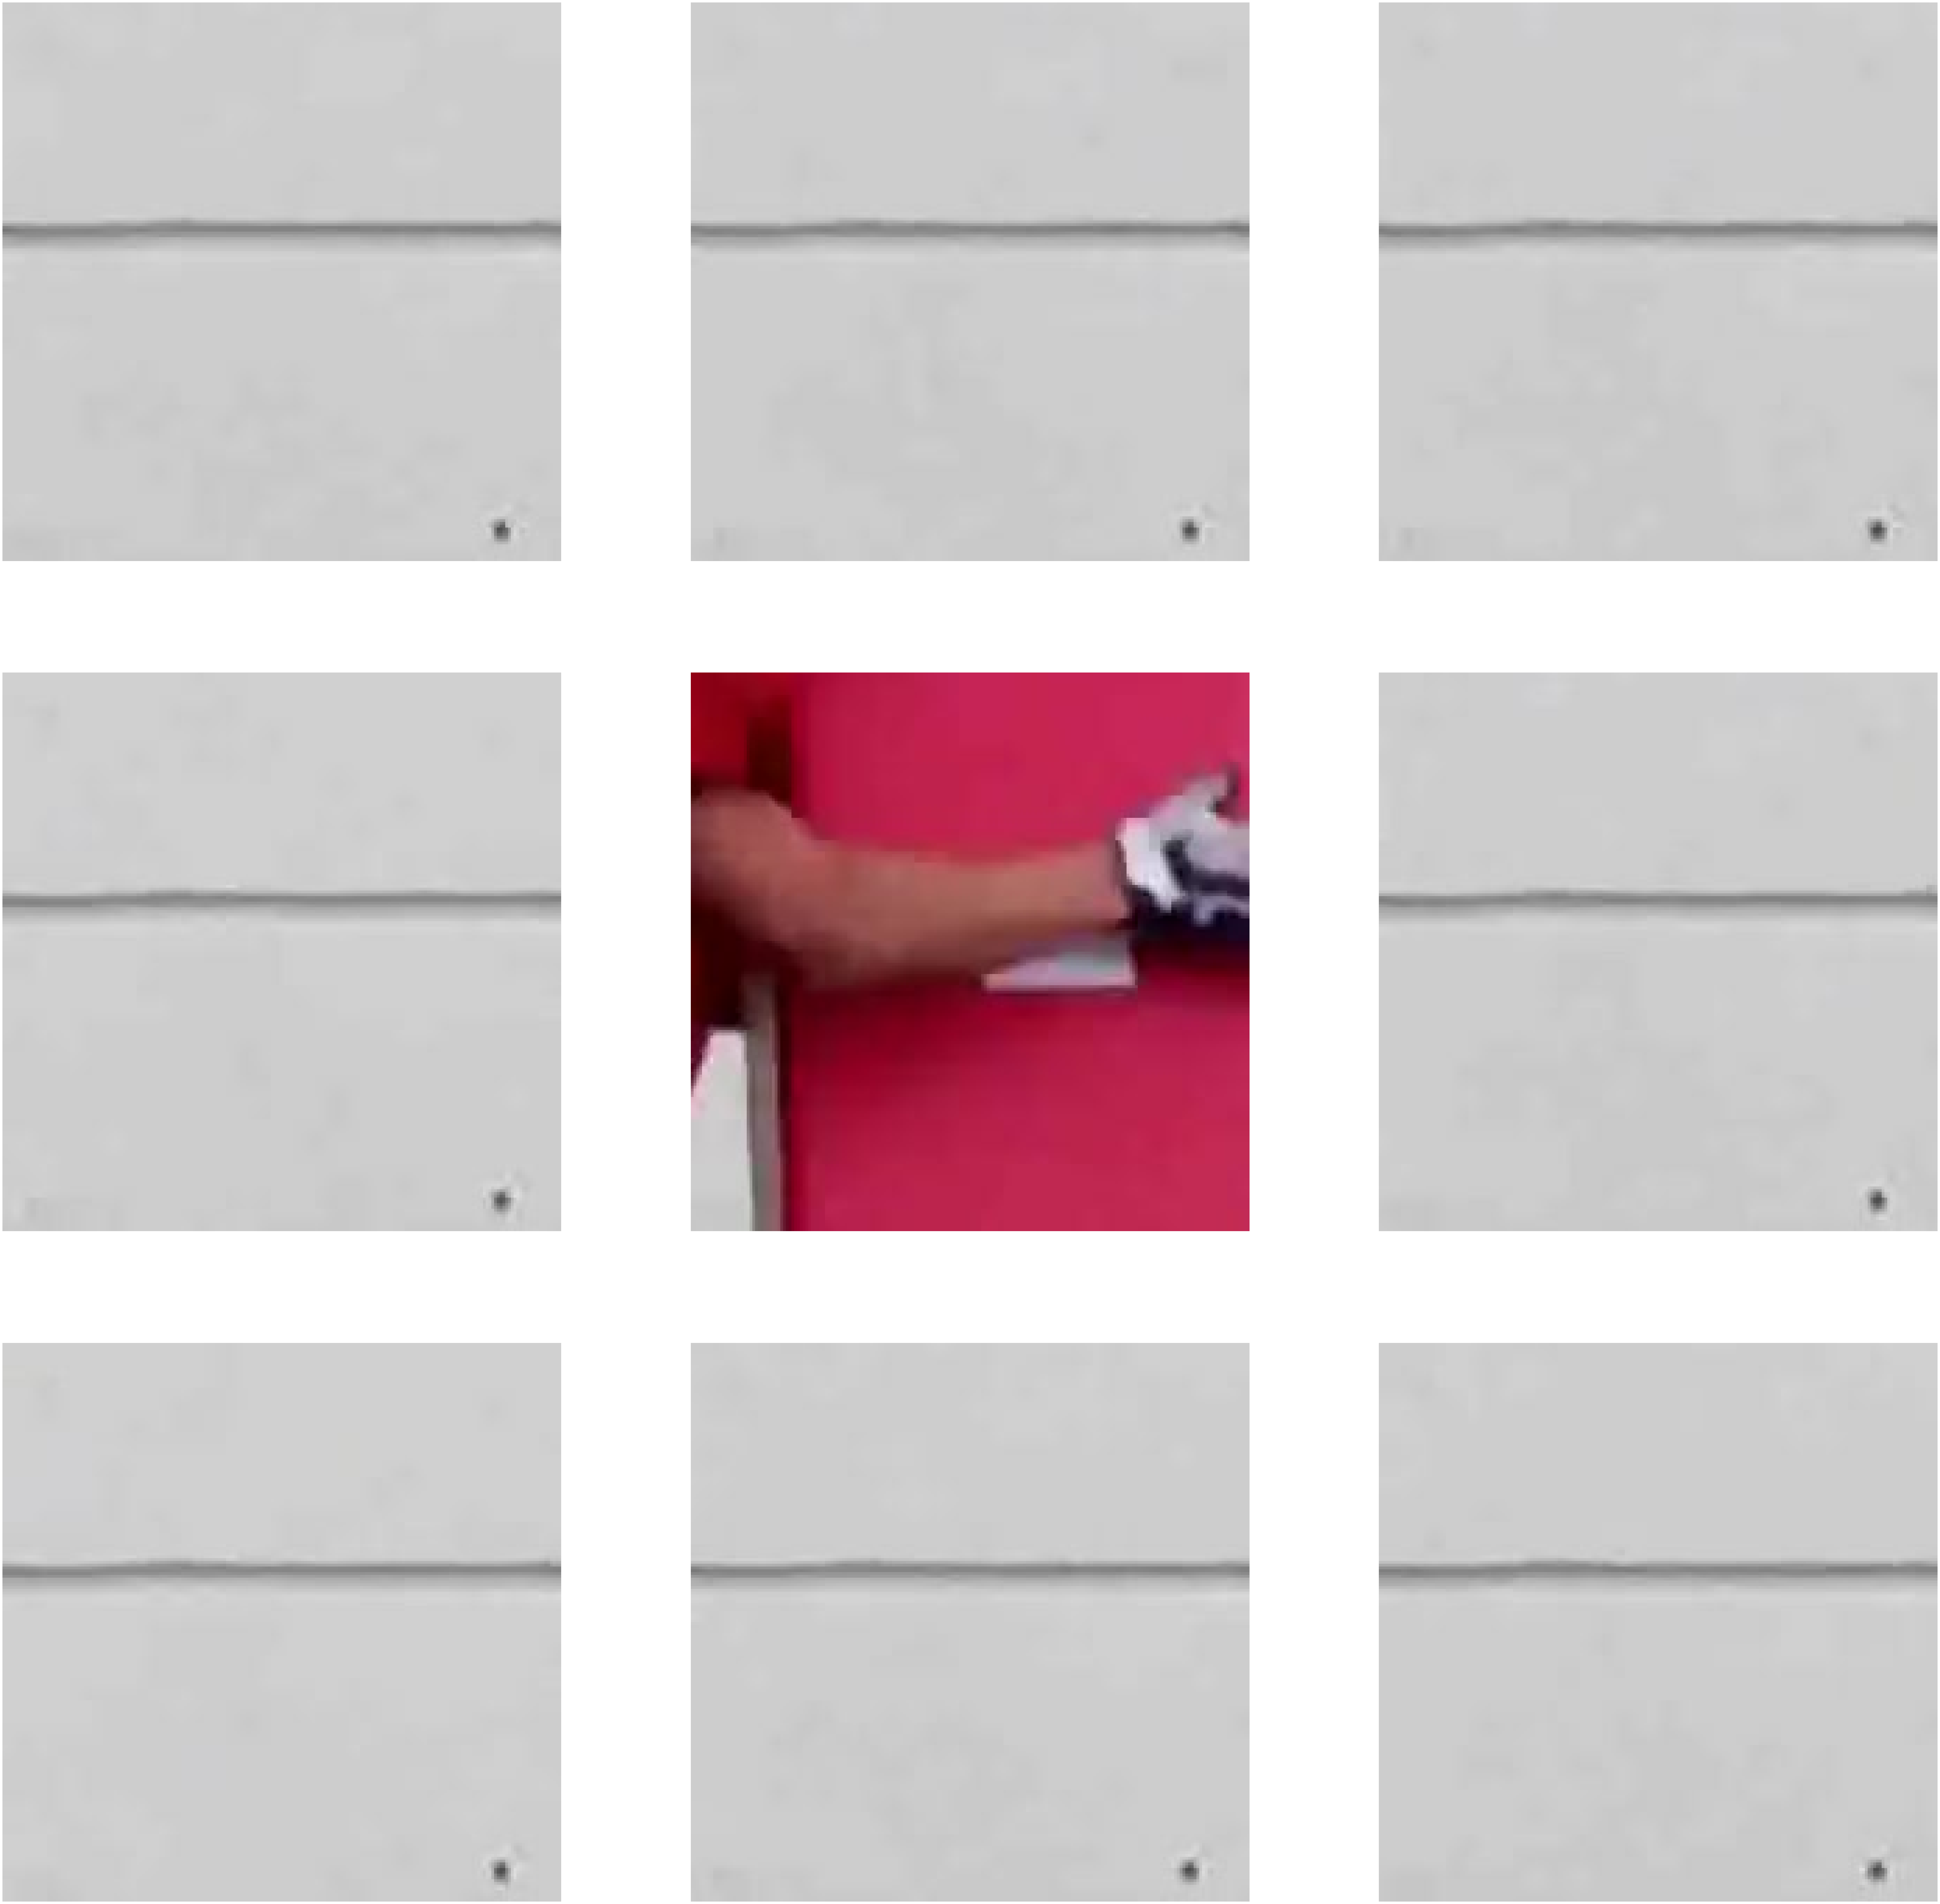

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 100))
for images, labels in x_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")

##Convert tf.data.Dataset to Numpy arrays##

In [101]:
import tensorflow_datasets as tfds

In [102]:
x_train = None

for image, label in tfds.as_numpy(x_train_ds):
  print(type(image), type(label), label, len(label))
  x_train = image
  print('------')

<class 'numpy.ndarray'> <class 'numpy.ndarray'> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 20
------


In [103]:
x_test = None

for image, label in tfds.as_numpy(x_test_ds):
  print(type(image), type(label), label, len(label))
  x_test = image
  print('------')

<class 'numpy.ndarray'> <class 'numpy.ndarray'> [0 0 0 0 0 0 0 0 0 0 0 0 0] 13
------


In [104]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

##Convolutional Autoencoder architecture##

In [107]:
## Hyperparameters
C = 3
## Latent space
latent_dim = 128

In [108]:
## Building the encoder
inputs = layers.Input(shape=(img_height, img_width, C), name="inputs")
x = inputs

x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.MaxPool2D((2,2))(x)

print('shape after encoder: ', x.shape)

x = layers.Flatten()(x)
units = x.shape[1]
x = layers.Dense(latent_dim, name="latent")(x)


## Building the decoder
x = layers.Dense(units)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((50, 50, 32))(x)

x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Conv2DTranspose(C, (3,3), strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("sigmoid", name="outputs")(x)

outputs = x

shape after encoder:  (None, 50, 50, 32)


In [109]:
print(x.shape)

(None, 200, 200, 3)


In [110]:
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 200, 200, 32)      128       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 100, 100, 32)      128 

In [134]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [135]:
history = autoencoder.fit(x_train, x_train,
                epochs=10000,
                batch_size=256,
                callbacks=[callback],
                shuffle=False,
                validation_data=(x_test, x_test))

Epoch 1/10000
1/1 [==============================] - 0s 124ms/step - loss: 0.4961 - val_loss: 0.5222
Epoch 2/10000
1/1 [==============================] - 0s 67ms/step - loss: 0.4961 - val_loss: 0.5221
Epoch 3/10000
1/1 [==============================] - 0s 66ms/step - loss: 0.4961 - val_loss: 0.5223
Epoch 4/10000
1/1 [==============================] - 0s 75ms/step - loss: 0.4961 - val_loss: 0.5221
Epoch 5/10000
1/1 [==============================] - 0s 66ms/step - loss: 0.4961 - val_loss: 0.5223
Epoch 6/10000
1/1 [==============================] - 0s 65ms/step - loss: 0.4961 - val_loss: 0.5222
Epoch 7/10000
1/1 [==============================] - 0s 73ms/step - loss: 0.4961 - val_loss: 0.5222
Epoch 8/10000
1/1 [==============================] - 0s 68ms/step - loss: 0.4961 - val_loss: 0.5223
Epoch 9/10000
1/1 [==============================] - 0s 68ms/step - loss: 0.4961 - val_loss: 0.5221
Epoch 10/10000
1/1 [==============================] - 0s 79ms/step - loss: 0.4961 - val_loss: 0.522

## Visualize the model loss ##

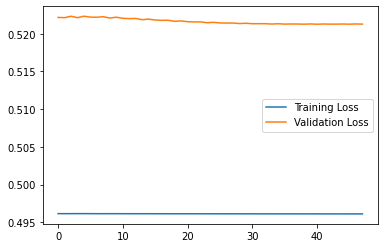

In [136]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [137]:
test_pred_y = autoencoder.predict(x_test)

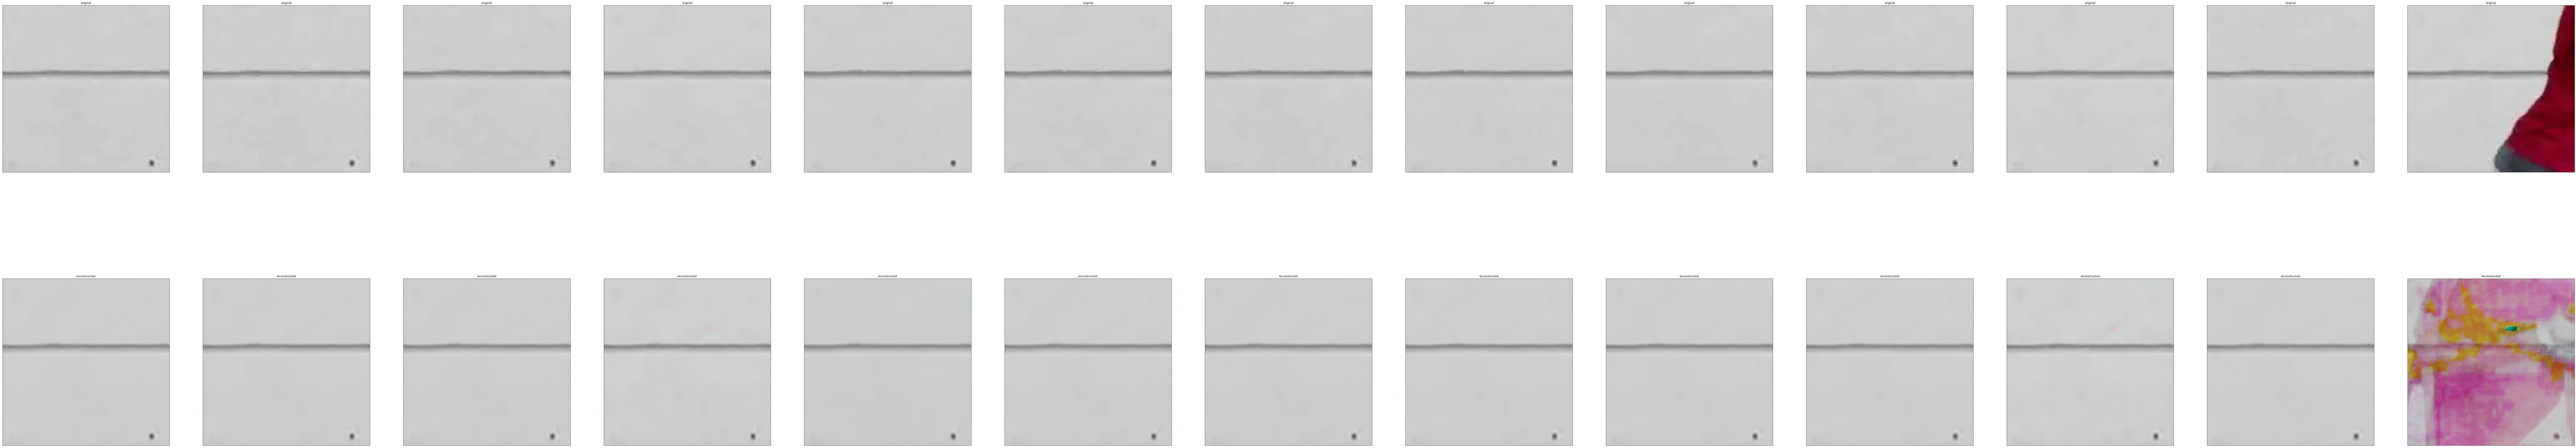

In [138]:
n = len(x_test)
plt.figure(figsize=(200, 40))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  #print(f'i: {i}')
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_pred_y[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()